### This is a demo for artpop for showing a color magnitude diagram of a *simple* composite stellar population with magnitude in I band versus V-I as axes, and finding the magnitude of the TRGB (last cell is the answer).

In [1]:
# Third-party imports 
import numpy as np
import matplotlib.pyplot as plt 
from astropy import units as u 
  

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(112)

# setup for ages, photometric system, and etc.
imf = 'kroupa'  # initial mass function
phot_system = 'UBVRIplus'
log_ages = artpop.MISTIsochrone._log_age_grid[40:-3]

print(artpop.filters.get_filter_names('UBVRIplus'))

['Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf', 'Gaia_RP_MAW', 'TESS']


We then use the make composite stellar population using 3 SSPs:

In [2]:
ssp_old = artpop.MISTSSP(
    log_age = 10,       # log of age in years
    feh = -1.5,           # metallicity [Fe/H]
    phot_system = phot_system, # photometric system(s)
    num_stars = 1e7,      # number of stars
    random_state = rng,   # random state for reproducibility
    ab_or_vega = 'vega'   # Vega mag system
)
RGB_old = ssp_old.select_phase('RGB')
AGB_old = ssp_old.select_phase('AGB')
TPAGB_old = ssp_old.select_phase('TPAGB')

ssp_intermediate = artpop.MISTSSP(
    log_age = 9.11,        # log of age in years
    feh = -1,             # metallicity [Fe/H]
    phot_system = phot_system, # photometric system(s)
    num_stars = 2e7,      # number of stars
    random_state = rng,   # random state for reproducibility
    ab_or_vega = 'vega'   # Vega mag system
)
RGB_intermediate = ssp_intermediate.select_phase('RGB')
AGB_intermediate = ssp_intermediate.select_phase('AGB')
TPAGB_intermediate = ssp_intermediate.select_phase('TPAGB')

ssp_young = artpop.MISTSSP(
    log_age = 8.20 ,        # log of age in years
    feh = 0,              # metallicity [Fe/H]
    phot_system = phot_system, # photometric system(s)
    num_stars = 4e6,      # number of stars
    random_state = rng,   # random state for reproducibility
    ab_or_vega = 'vega'   # Vega mag system
)
RGB_young = ssp_young.select_phase('RGB')
AGB_young = ssp_young.select_phase('AGB')
TPAGB_young = ssp_young.select_phase('TPAGB')

In [3]:
# Get the magnitude for different filters/bandpass
I_old = ssp_old.star_mags('Bessell_I')
V_old = ssp_old.star_mags('Bessell_V')
H_old = ssp_old.star_mags('2MASS_H')
J_old = ssp_old.star_mags('2MASS_J')
K_old = ssp_old.star_mags('2MASS_Ks')

I_intermediate = ssp_intermediate.star_mags('Bessell_I')
V_intermediate = ssp_intermediate.star_mags('Bessell_V')
H_intermediate = ssp_intermediate.star_mags('2MASS_H')
J_intermediate = ssp_intermediate.star_mags('2MASS_J')
K_intermediate = ssp_intermediate.star_mags('2MASS_Ks')

I_young = ssp_young.star_mags('Bessell_I')
V_young = ssp_young.star_mags('Bessell_V')
H_young = ssp_young.star_mags('2MASS_H')
J_young = ssp_young.star_mags('2MASS_J')
K_young = ssp_young.star_mags('2MASS_Ks')

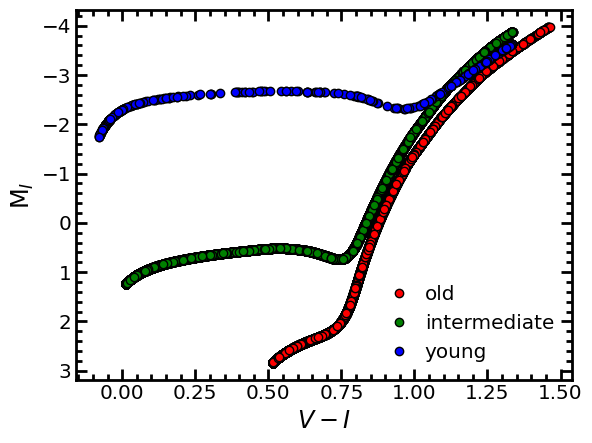

In [4]:
# plot V-I - I

plt.plot(V_old[RGB_old] - I_old[RGB_old], I_old[RGB_old], 'o', 
         c='red', label='old', mec='k')
plt.plot(V_intermediate[RGB_intermediate] - I_intermediate[RGB_intermediate], I_intermediate[RGB_intermediate], 'o', 
         c='green', label='intermediate', mec='k')
plt.plot(V_young[RGB_young] - I_young[RGB_young], I_young[RGB_young], 'o', 
         c='blue', label='young', mec='k')

plt.legend()
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel(r'$V-I$')
plt.ylabel(r'M$_I$');

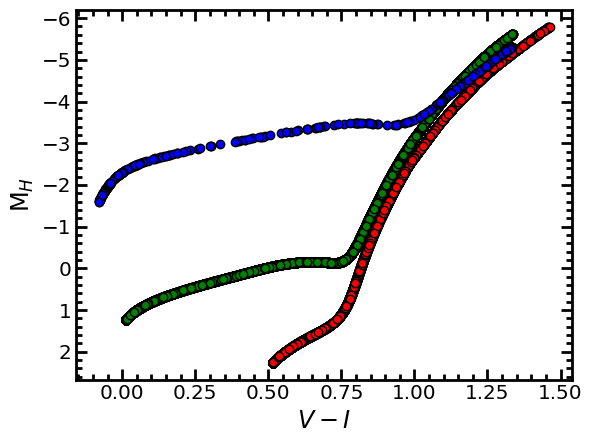

In [5]:
plt.plot(V_old[RGB_old] - I_old[RGB_old], H_old[RGB_old], 'o', 
         c='red', label = 'old', mec='k')
plt.plot(V_intermediate[RGB_intermediate] - I_intermediate[RGB_intermediate], H_intermediate[RGB_intermediate], 'o', 
         c='green', label = 'intermediate', mec='k')
plt.plot(V_young[RGB_young] - I_young[RGB_young], H_young[RGB_young], 'o', 
         c='blue', label = 'young', mec='k')
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel(r'$V-I$')
plt.ylabel(r'M$_H$');

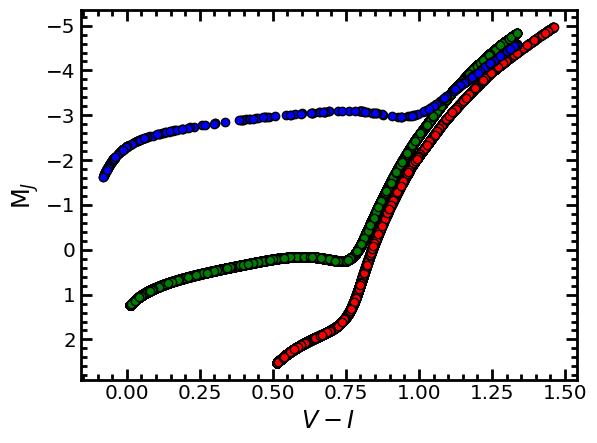

In [6]:
plt.plot(V_old[RGB_old] - I_old[RGB_old], J_old[RGB_old], 'o', 
         c='red', label='old', mec='k')
plt.plot(V_intermediate[RGB_intermediate] - I_intermediate[RGB_intermediate], J_intermediate[RGB_intermediate], 'o', 
         c='green', label='intermediate', mec='k')
plt.plot(V_young[RGB_young] - I_young[RGB_young], J_young[RGB_young], 'o', 
         c='blue', label='young', mec='k')
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel(r'$V-I$')
plt.ylabel(r'M$_J$');

Now we implement a tip detection algorithm. In the J. Wu et al. 2022 paper, Sobel edge detection is used. We first create a magnitude histogram to find luminosity function: 

In [7]:
import pandas as pd
import seaborn as sns
import scipy

mags = pd.DataFrame()
mags['mag_I'] = np.concatenate((I_old[RGB_old], I_intermediate[RGB_intermediate], I_young[RGB_young]))
mags['mag_V'] = np.concatenate((V_old[RGB_old], V_intermediate[RGB_intermediate], V_young[RGB_young]))
mags['mag_H'] = np.concatenate((H_old[RGB_old], H_intermediate[RGB_intermediate], H_young[RGB_young]))
mags['mag_J'] = np.concatenate((J_old[RGB_old], J_intermediate[RGB_intermediate], J_young[RGB_young]))

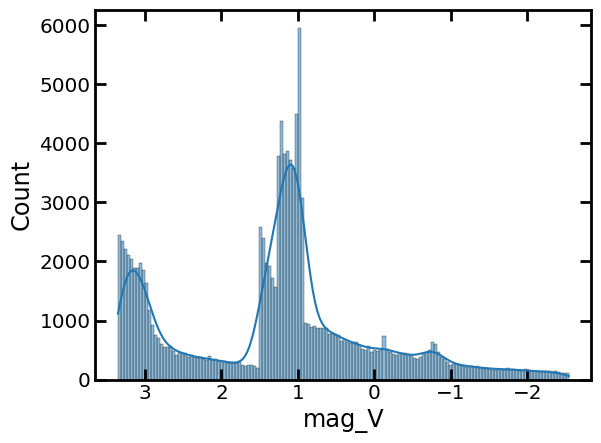

In [8]:
ax_V = sns.histplot(mags['mag_V'], bins = 150, kde=True)
ax_V.invert_xaxis()


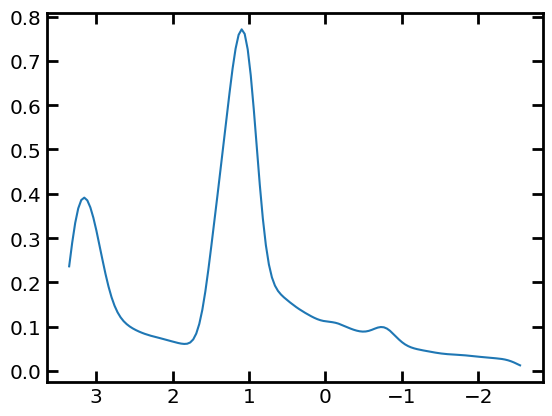

In [9]:
hist_V, bin_edges_V = np.histogram(mags['mag_V'], bins=150, density = False)
eval_points_V = np.linspace(np.min(bin_edges_V), np.max(bin_edges_V), num = 150)
kde_V = scipy.stats.gaussian_kde(mags['mag_V'])
plt.plot(eval_points_V, kde_V.pdf(eval_points_V))
plt.gca().invert_xaxis()

Maximum mag of red giant branch on V band = -2.546258883988908


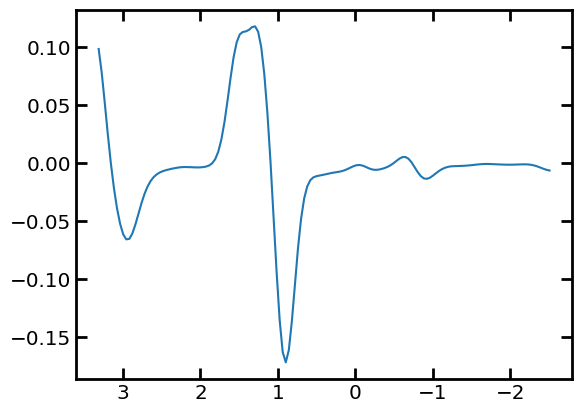

In [10]:
sobel_op = [1,0,-1]
sobel_response_V = []
kde_points_V = kde_V.pdf(eval_points_V)
for i in range(len(eval_points_V)-2):
    sobel_response_V.append(kde_points_V[i]*sobel_op[0] + kde_points_V[i+1]*sobel_op[1] + kde_points_V[i+2]*sobel_op[2]) 

plt.plot(eval_points_V[1:-1],sobel_response_V)
plt.gca().invert_xaxis()
# print('Maximum mag of red giant branch on V band =',eval_points_V[np.argmax(sobel_response_V)])
print('Maximum mag of red giant branch on V band =', np.min(eval_points_V))

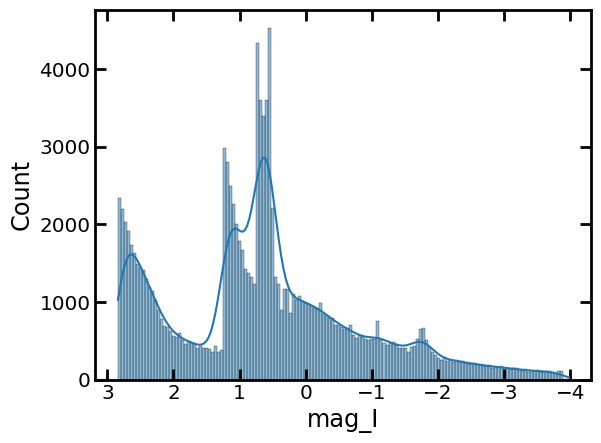

In [11]:
ax_I = sns.histplot(mags['mag_I'], bins = 150, kde=True)
ax_I.invert_xaxis()

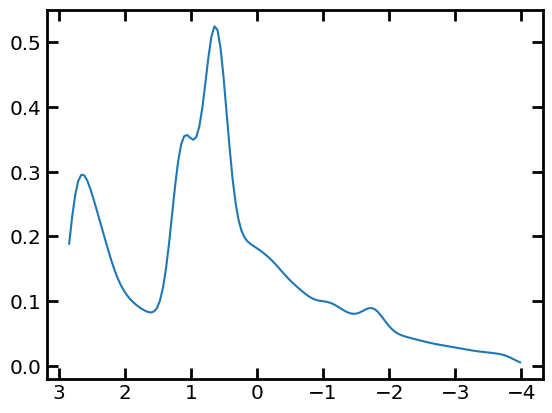

In [12]:
hist_I, bin_edges_I = np.histogram(mags['mag_I'], bins=150, density = False)
eval_points_I = np.linspace(np.min(bin_edges_I), np.max(bin_edges_I), num = 150)
kde_I = scipy.stats.gaussian_kde(mags['mag_I'])
plt.plot(eval_points_I, kde_I.pdf(eval_points_I))
plt.gca().invert_xaxis()

Maximum mag of red giant branch on I band = -3.9791499210128802


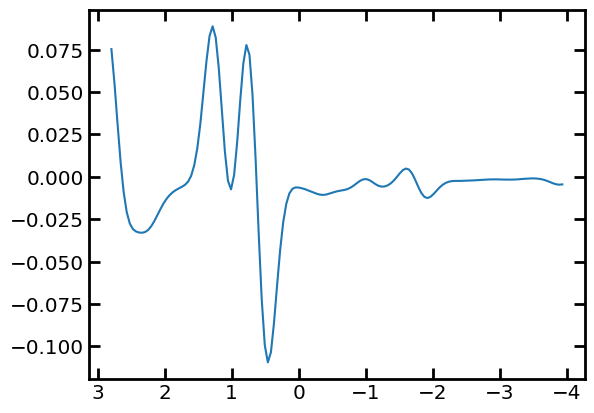

In [13]:
sobel_op = [1,0,-1]
sobel_response_I = []
kde_points_I = kde_I.pdf(eval_points_I)
for i in range(len(eval_points_I)-2):
    sobel_response_I.append(kde_points_I[i]*sobel_op[0] + kde_points_I[i+1]*sobel_op[1] + kde_points_I[i+2]*sobel_op[2]) 

plt.plot(eval_points_I[1:-1],sobel_response_I)
plt.gca().invert_xaxis()
# print('Maximum mag of red giant branch on I band =',eval_points_I[np.argmax(sobel_response_I)])
print('Maximum mag of red giant branch on I band =', np.min(eval_points_I))

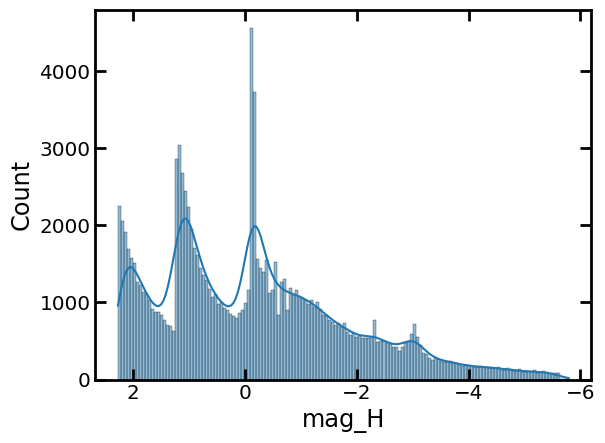

In [14]:
ax_H = sns.histplot(mags['mag_H'], bins = 150, kde=True)
ax_H.invert_xaxis()

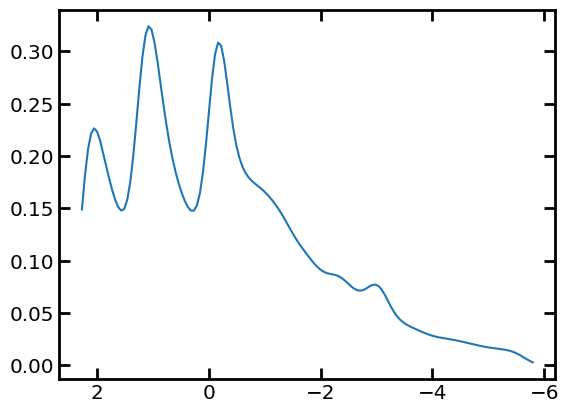

In [15]:
hist_H, bin_edges_H = np.histogram(mags['mag_H'], bins=150, density = False)
eval_points_H = np.linspace(np.min(bin_edges_H), np.max(bin_edges_H), num = 150)
kde_H = scipy.stats.gaussian_kde(mags['mag_H'])
plt.plot(eval_points_H, kde_H.pdf(eval_points_H))
plt.gca().invert_xaxis()

Maximum mag of red giant branch on H band = -5.793103294793951


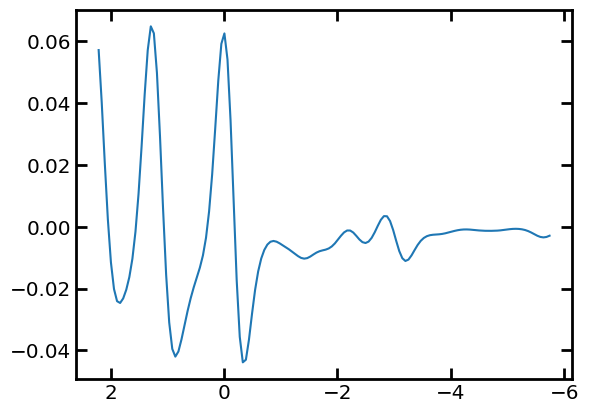

In [16]:
sobel_op = [1,0,-1]
sobel_response_H = []
kde_points_H = kde_H.pdf(eval_points_H)
for i in range(len(eval_points_H)-2):
    sobel_response_H.append(kde_points_H[i]*sobel_op[0] + kde_points_H[i+1]*sobel_op[1] + kde_points_H[i+2]*sobel_op[2]) 

plt.plot(eval_points_H[1:-1],sobel_response_H)
plt.gca().invert_xaxis()
# print('Maximum mag of red giant branch on I band =',eval_points_H[np.argmax(sobel_response_H)])
print('Maximum mag of red giant branch on H band =', np.min(eval_points_H))

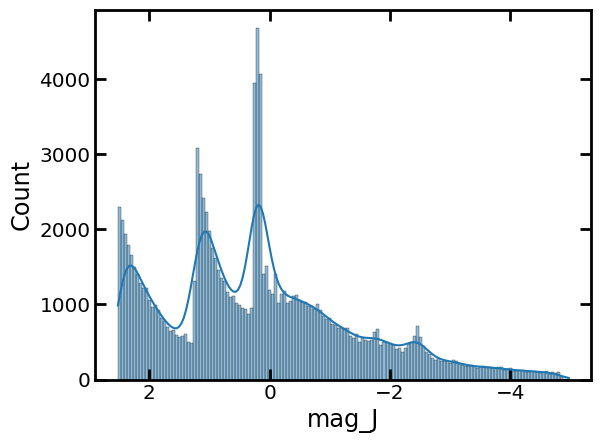

In [17]:
ax_J = sns.histplot(mags['mag_J'], bins = 150, kde=True)
ax_J.invert_xaxis()

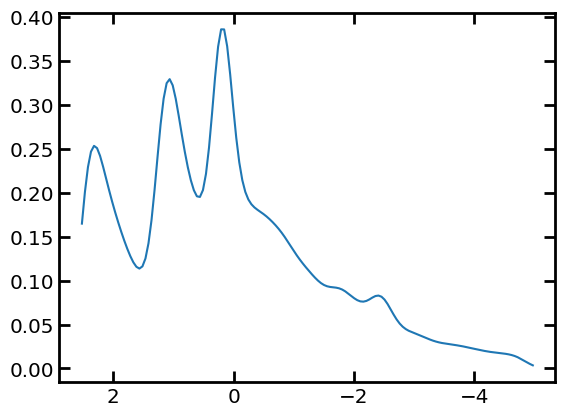

In [18]:
hist_J, bin_edges_J = np.histogram(mags['mag_J'], bins=150, density = False)
eval_points_J = np.linspace(np.min(bin_edges_J), np.max(bin_edges_J), num = 150)
kde_J = scipy.stats.gaussian_kde(mags['mag_J'])
plt.plot(eval_points_J, kde_J.pdf(eval_points_J))
plt.gca().invert_xaxis()

Maximum mag of red giant branch on J band = -4.974344852583678


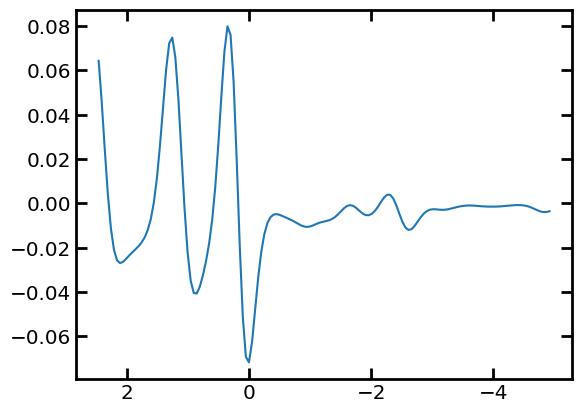

In [19]:
sobel_op = [1,0,-1]
sobel_response_J = []
kde_points_J = kde_J.pdf(eval_points_J)
for i in range(len(eval_points_J)-2):
    sobel_response_J.append(kde_points_J[i]*sobel_op[0] + kde_points_J[i+1]*sobel_op[1] + kde_points_J[i+2]*sobel_op[2]) 

plt.plot(eval_points_J[1:-1],sobel_response_J)
plt.gca().invert_xaxis()
# print('Maximum mag of red giant branch on I band =',eval_points_J[np.argmax(sobel_response_J)])
print('Maximum mag of red giant branch on J band =', np.min(eval_points_J))

In [20]:
print('Maximum mag of red giant branch on I , H , J band =', np.min(eval_points_I), np.min(eval_points_H), np.min(eval_points_J))

Maximum mag of red giant branch on I , H , J band = -3.9791499210128802 -5.793103294793951 -4.974344852583678


We now try to find the Center of the AGB with J-K vs J:

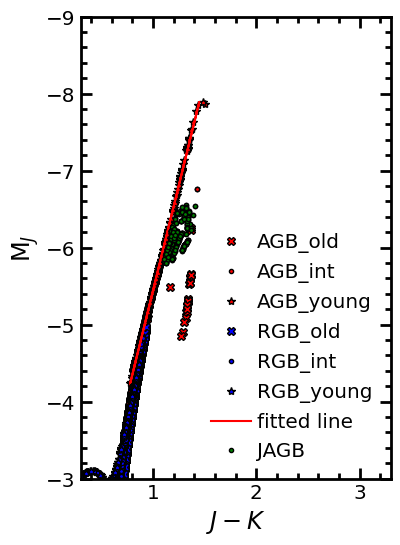

In [21]:
# plot J-K - J for AGB

plt.figure(figsize=(8, 12), dpi=100)

plt.plot(J_old[AGB_old] - K_old[AGB_old], J_old[AGB_old], 'X', 
         c='red', label='AGB_old', mec='k')
plt.plot(J_intermediate[AGB_intermediate] - K_intermediate[AGB_intermediate], J_intermediate[AGB_intermediate], '.', 
         c='red', label='AGB_int', mec='k')
plt.plot(J_young[AGB_young] - K_young[AGB_young], J_young[AGB_young], '*', 
         c='red', label='AGB_young', mec='k')

plt.plot(J_old[RGB_old] - K_old[RGB_old], J_old[RGB_old], 'X', 
         c='blue', label='RGB_old', mec='k')
plt.plot(J_intermediate[RGB_intermediate] - K_intermediate[RGB_intermediate], J_intermediate[RGB_intermediate], '.', 
         c='blue', label='RGB_int', mec='k')
plt.plot(J_young[RGB_young] - K_young[RGB_young], J_young[RGB_young], '*', 
         c='blue', label='RGB_young', mec='k')


y_y, x_y = J_young[AGB_young] - K_young[AGB_young], J_young[AGB_young]
y_i, x_i = J_intermediate[AGB_intermediate] - K_intermediate[AGB_intermediate], J_intermediate[AGB_intermediate]
y_o, x_o = J_old[AGB_old] - K_old[AGB_old], J_old[AGB_old]

res = scipy.stats.linregress(x_y,y_y)
plt.plot(res.intercept + res.slope*x_y, x_y, 'r', label='fitted line')

mag_cut_i = np.all([x_i>-6.65, x_i<-5.75], axis=0)
color_cut_i = np.all([y_i > res.intercept + res.slope*x_i+0.03], axis=0)
mag_cut_o = np.all([x_o>-6.65, x_o<-5.75], axis=0)
color_cut_o = np.all([y_o > res.intercept + res.slope*x_o+0.03], axis=0)

color = np.concatenate((y_i[np.all([mag_cut_i, color_cut_i], axis=0)], y_o[np.all([mag_cut_o, color_cut_o], axis=0)]))
mag = np.concatenate((x_i[np.all([mag_cut_i, color_cut_i], axis=0)], x_o[np.all([mag_cut_o, color_cut_o], axis=0)]))
plt.plot(color, mag, '.', c='green', label='JAGB', mec='k')



plt.xlim(0.3,3.3)
plt.ylim(-9,-3)
plt.legend(loc=4)
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel(r'$J-K$')
plt.ylabel(r'M$_J$');


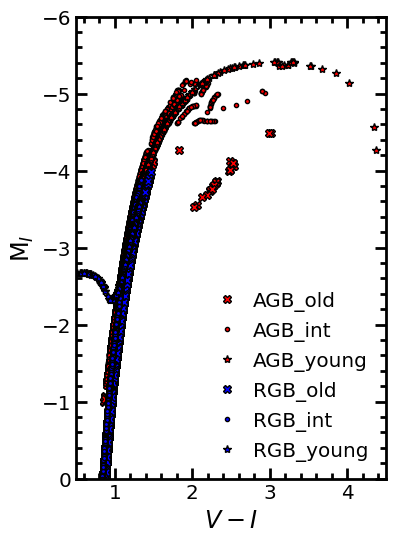

In [22]:
# plot J-K - J for AGB

plt.figure(figsize=(4, 6), dpi=100)

plt.plot(V_old[AGB_old] - I_old[AGB_old], I_old[AGB_old], 'X', 
         c='red', label='AGB_old', mec='k')
plt.plot(V_intermediate[AGB_intermediate] - I_intermediate[AGB_intermediate], I_intermediate[AGB_intermediate], '.', 
         c='red', label='AGB_int', mec='k')
plt.plot(V_young[AGB_young] - I_young[AGB_young], I_young[AGB_young], '*', 
         c='red', label='AGB_young', mec='k')

plt.plot(V_old[RGB_old] - I_old[RGB_old], I_old[RGB_old], 'X', 
         c='blue', label='RGB_old', mec='k')
plt.plot(V_intermediate[RGB_intermediate] - I_intermediate[RGB_intermediate], I_intermediate[RGB_intermediate], '.', 
         c='blue', label='RGB_int', mec='k')
plt.plot(V_young[RGB_young] - I_young[RGB_young], I_young[RGB_young], '*', 
         c='blue', label='RGB_young', mec='k')


plt.xlim(0.5,4.5)
plt.ylim(-6,0)
plt.legend(loc=4)
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel(r'$V-I$')
plt.ylabel(r'M$_I$');

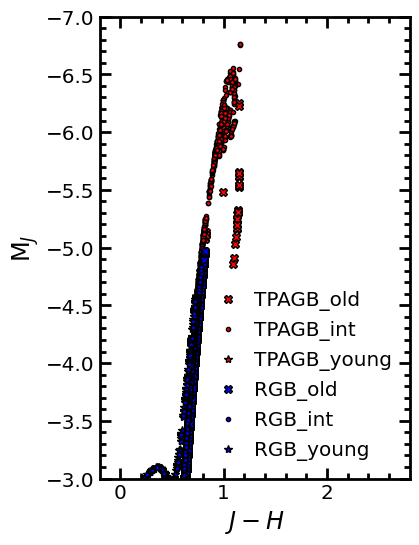

In [23]:
# plot J-K - J for TPAGB

plt.figure(figsize=(4, 6), dpi=100)

plt.plot(J_old[TPAGB_old] - H_old[TPAGB_old], J_old[TPAGB_old], 'X', 
         c='red', label='TPAGB_old', mec='k')
plt.plot(J_intermediate[TPAGB_intermediate] - H_intermediate[TPAGB_intermediate], J_intermediate[TPAGB_intermediate], '.', 
         c='red', label='TPAGB_int', mec='k')
plt.plot(J_young[TPAGB_young] - H_young[TPAGB_young], J_young[TPAGB_young], '*', 
         c='red', label='TPAGB_young', mec='k')

plt.plot(J_old[RGB_old] - H_old[RGB_old], J_old[RGB_old], 'X', 
         c='blue', label='RGB_old', mec='k')
plt.plot(J_intermediate[RGB_intermediate] - H_intermediate[RGB_intermediate], J_intermediate[RGB_intermediate], '.', 
         c='blue', label='RGB_int', mec='k')
plt.plot(J_young[RGB_young] - H_young[RGB_young], J_young[RGB_young], '*', 
         c='blue', label='RGB_young', mec='k')

plt.xlim(-0.2,2.8)
plt.ylim(-7,-3)
plt.legend(loc=4)
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel(r'$J-H$')
plt.ylabel(r'M$_J$');



Average mag of JRGB = -6.163607417037212


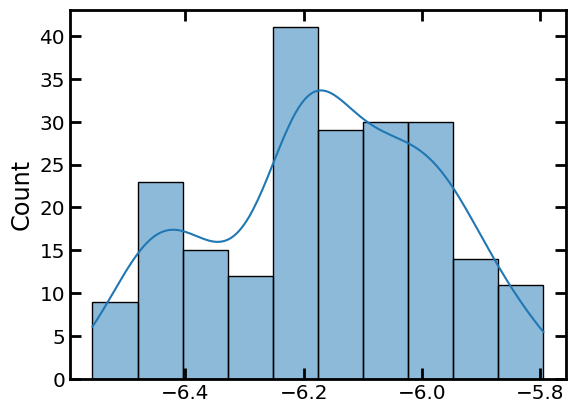

In [24]:
sns.histplot(data = mag, bins = 10, kde= True)
print('Average mag of JRGB =', np.average(mag))